# Analysis of PAMAP2 Physical Activity Monitoring Dataset for Developing Activity Detection System

## Table of contents
1. [Introduction](#introduction)<br>
    1.1. [Overview](#overview)<br>
    1.2. [Data Description](#data_description)
2. [Preliminary Tasks](#preliminary_tasks)<br>
    2.1. [Environment Setup](#environment_setup)<br>
    2.2. [Data Ingestion](#data_ingestion)
3. [Data Munging and Cleaning](#munging_cleaning)<br>
    3.1. [Data Filtering](#data_filtering)<br>
    3.2. [Check/Remove Duplicates](#check/remove_duplicates)<br>
    3.3. [Missing Values](#missing_values)<br>
    3.4. [Add Columns](#add_columns)<br>
    3.5. [Dropping Columns](#dropping_columns)
4. [Split Data for EDA and Hypothesis Testing](#splitting_data)
5. [Exploratory Data Analysis(EDA)](#eda)<br>
    5.1. [Correlation Analysis](#correlation)<br>
    5.2. [Data Distribution Analysis](#dda)<br>
    5.3. [Heart Rate Analysis](#heartrate_analysis)<br>
    5.4. [Acceleration Analysis](#acceleration_analysis)<br>
    5.5. [Angular Velocity Analysis](#velocity_analysis)<br>
    5.6. [Magnetic Field Analysis](#magnetic_analysis)<br>
    5.7. [Temprature Analysis](#temprature_analysis)
6. [Hypothesis Testing](#hypothesis_testing)<br>
    6.1. [Hypothesis Case 1](#hypothesis1)<br>
    6.2. [Hypothesis Case 2](#hypothesis2)<br>
    6.3. [Hypothesis Case 3](#hypothesis3)
7. [Modelling](#modelling)<br>
    7.1. [Split data into Train, Valid, and Test Dataset ](#train_valid_test)<br>
    7.2. [Models](#models)<br>
    7.3. [Models using PCA](#pca_models)<br>
    7.4. [K-fold Cross Validation](#kfold)
8. [Summary](#summary)
9. [References](#references)

<a name="introduction"></a>
## 1. Introduction

<a name="overview"></a>
### 1.1. Overview
The goal of this report is to develop hardware and/or software that can accurately measure and classify physical activity based on start/end times, heart rates, and data from IMUs (inertial measurement units) worn on the chest, hand, and ankle. We will be using the *PAMAP2 Physical Activity Monitoring dataset* [[1]](#1) for this report.

We will conduct a thorough exploratory data analysis to meet this objective, and we will properly handle any missing or imperfect data. Furthermore, we'll create and test hypotheses about the association between attributes as well as test models that combine several attributes to make predictions.

The outcome of this report will be used to provide actionable insights into an individual's physical activity levels and the type of activity they are engaging in. The insights generated from this analysis will enable individuals to better understand their physical activity levels, and make more informed decisions about their health and fitness.

<a name="data_description"></a>
### 1.2. Data Description
The dataset includes data from 9 subjects who were wearing 3 inertial measurement units (IMUs) and a heart rate monitor while they engaged in 18 different physical activities (such as walking, cycling, playing soccer, running, rope jumping, etc.). Per subject, this information is kept in separate text files. There are 54 attributes and one reading per row in each file (including timestamp, activity ID, heart rate and IMU sensory data). One data file per subject per session (protocol or optional), available as text files(.dat), combines synchronised and labelled raw data from all the sensors (three IMUs and the HR monitor).

Each of the data-files contains 54 columns per row, the columns contain the following data:
   - 1 timestamp (s)
   - 2 activityID 
   - 3 heart rate (bpm)
   - 4-20 IMU hand
   - 21-37 IMU chest
   - 38-54 IMU ankle

The IMU sensory data contains the following columns:
   - 1 temperature (°C)
   - 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
   - 5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
   - 8-10 3D-gyroscope data (rad/s)
   - 11-13 3D-magnetometer data (μT)
   - 14-17 orientation


<a name="preliminary_tasks"></a>
## 2. Preliminary Tasks

<a name="environment_setup"></a>
### 2.1. Environment Setup
Let's prepare the environment for this analysis by importing all necessary libraries and tools for data analysis, visualization, hypothesis testing, and modeling.

In [1]:
#preliminary imports

#standard imports for when working with pandas
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

#setup for hypothesis testing
from scipy.stats import spearmanr,ttest_ind

#setup for modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import sklearn.decomposition as decomp
from sklearn.model_selection import KFold

#other useful tools
import os
import random
from IPython.display import display

<a name="data_ingestion"></a>
### 2.2. Data Ingestion
Loading the data into memory to conduct the analysis. Additionally, the columns were named in accordance with how the data is described. There are three IMU sensors listed in the data description, and each one has three columns listing its measurements (x,y,z) and four columns are used to describe the orientation (x,y,z,w), and a new column called "subject_id" is added to help distinguish between the 9 subjects.


In [2]:
#read the files and load it to a dataframe

#defining metadata file paths.
protocol_files = os.listdir("PAMAP2_Dataset/PAMAP2_Dataset/Protocol/")
optional_files = os.listdir("PAMAP2_Dataset/PAMAP2_Dataset/Optional/")

#create a df for loading the files
df = pd.DataFrame()

#alloting columns names as per the data description
column_names = ['timestamp', 'activity_id', 'heart_rate']
organs = ['hand', 'chest', 'ankle']
sensors = ['acceleration_16', 'acceleration_6', 'gyroscope', 'magnetometer', 'orientation']
for organ in organs:
    column_names.append('{}_temperature'.format(organ))
    for sensor in sensors:
        column_names.append('{}_{}_x'.format(organ, sensor))
        column_names.append('{}_{}_y'.format(organ, sensor))
        column_names.append('{}_{}_z'.format(organ, sensor))
        if sensor == 'orientation':
            column_names.append('{}_{}_w'.format(organ, sensor))

#loading data in the protocol folder and assigning subject id's
for filename in protocol_files:
    _df = pd.read_csv('PAMAP2_Dataset/PAMAP2_Dataset/Protocol/{}'.format(filename), sep='\s+', names=column_names)
    _df['subject_id'] = [filename[7:10] for _ in range(len(_df))]
    df = pd.concat([df,_df],ignore_index=True)

#loading data in the optional folder and assigning subject id's
for filename in optional_files:
    _df = pd.read_csv('PAMAP2_Dataset/PAMAP2_Dataset/Optional/{}'.format(filename), sep='\s+', names=column_names)
    _df['subject_id'] = [filename[7:10] for _ in range(len(_df))]
    df = pd.concat([df,_df],ignore_index=True)

In [3]:
#looking at the first few rows of the data
df.head()

,timestamp,activity_id,heart_rate,hand_temperature,hand_acceleration_16_x,hand_acceleration_16_y,hand_acceleration_16_z,hand_acceleration_6_x,hand_acceleration_6_y,hand_acceleration_6_z,...,ankle_gyroscope_y,ankle_gyroscope_z,ankle_magnetometer_x,ankle_magnetometer_y,ankle_magnetometer_z,ankle_orientation_x,ankle_orientation_y,ankle_orientation_z,ankle_orientation_w,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101


In [4]:
#checking the number of rows(movies) and columns(factors) in the dataframe
df.shape

(3850505, 55)

<a name="munging_cleaning"></a>
## 3. Data Munging and Cleaning

<a name="data_filtering"></a>
### 3.1. Data Filtering
As mentioned in the *readme.pdf* file of the dataset, data marked with `activity_id=0` should be ignored. This information primarily relates to transitional activities, such as moving from one location to the next activity's location or waiting for some equipment to be prepared. Additionally, different portions of one subject's recording were put together during these transitory activities (noticeable by some "jumping" in the HR-data in the event that the data collection was abandoned for some reason).

In [5]:
#removing all rows with activity_id as 0
df.drop(df[df.activity_id == 0].index, inplace=True)

In [6]:
#checking the number of rows(movies) and columns(factors) in the dataframe
df.shape

(2724953, 55)

<a name="check/remove_duplicates"></a>
### 3.2. Check/Remove Duplicates

Check for duplicates and remove if any.

In [7]:
df.duplicated().sum()

0

<a name="missing_values"></a>
### 3.3. Missing Values

We must comprehend the proportion of missing values in each column in order to select the appropriate method for handling NaN values.

In [8]:
#displaying the percentage of NaN values per coloumn
df.isna().sum()/df.shape[0]*100

timestamp                   0.000000
activity_id                 0.000000
heart_rate                 90.868576
hand_temperature            0.435530
hand_acceleration_16_x      0.435530
hand_acceleration_16_y      0.435530
hand_acceleration_16_z      0.435530
hand_acceleration_6_x       0.435530
hand_acceleration_6_y       0.435530
hand_acceleration_6_z       0.435530
hand_gyroscope_x            0.435530
hand_gyroscope_y            0.435530
hand_gyroscope_z            0.435530
hand_magnetometer_x         0.435530
hand_magnetometer_y         0.435530
hand_magnetometer_z         0.435530
hand_orientation_x          0.435530
hand_orientation_y          0.435530
hand_orientation_z          0.435530
hand_orientation_w          0.435530
chest_temperature           0.112222
chest_acceleration_16_x     0.112222
chest_acceleration_16_y     0.112222
chest_acceleration_16_z     0.112222
chest_acceleration_6_x      0.112222
chest_acceleration_6_y      0.112222
chest_acceleration_6_z      0.112222
c

`'heart_rate'` has 90% NaNs because IMUs sample at 100 Hz (0.01s between points), whereas the HR monitor sampled at 9 Hz (0.11s between points), so discarding the NaNs is not an option here. Therefore, we perform multiple imputation by imputing the NaNs of per second by their mean heart rate per second..

In [9]:
#imputing NaNs of heart_rate
subjects = df.subject_id.unique()
#iterating through all the subjects
for subject in subjects:
    subject_df = df[df['subject_id'] == subject]
    activities = subject_df.activity_id.unique()
    #iterating through all the activities
    for activity in activities:
        activity_df = subject_df[subject_df['activity_id'] == activity]
        min_time = activity_df.timestamp.min()//1
        max_time = activity_df.timestamp.max()//1
        #iterating through every secound, determining the NaN indexs and imputing it with the time windows mean heart rate
        for time_window in np.arange(min_time,max_time+1):
            time_window_df = activity_df[activity_df['timestamp']//1 == time_window]
            nan_indexes = time_window_df.heart_rate.index[time_window_df['heart_rate'].apply(np.isnan)]
            df.loc[nan_indexes,'heart_rate'] = time_window_df.heart_rate.mean()

Now, let's see the percentage of remaining NaN values

In [10]:
#determine the percentage of rows with missing values.
(df.isna().sum(axis=1) > 0).sum()/df.shape[0]*100

0.8869510776883125

As only 0.88% of rows have missing values, we can remove these rows without suffering a significant data loss.

In [11]:
#dropping the NaN valued rows
df.dropna(inplace=True)

In [12]:
df.shape

(2700784, 55)

<a name="add_columns"></a>
### 3.4. Add Columns

We now calculate the overall acceleration from the three columns of 3D acceleration data of the three IMUs located on the chest, hand, and ankle to get the resultant acceleration of the 3-axis.
$$Resultant Acceleration: a_{(res)} = \sqrt {a_x^2 \, +\, a_y^2 \,+\, a_z^2}$$

Likewise, we calculate resultant angular velocity and magnetometer measure.
$$Resultant Angular Velocity: \omega_{(res)} = \sqrt {\omega_x^2 \, +\, \omega_y^2 \,+\, \omega_z^2}$$
$$Resultant Magnetometer Measure: B_{(res)} = \sqrt {B_x^2 \, +\, B_y^2 \,+\, B_z^2}$$

In [13]:
#determining resultant acceleration, angular velocity, and magnetometer measure for hand, chest and ankle
def get_resultant(x,y,z):
    return np.sqrt(np.power(x,2) + np.power(y,2) + np.power(z,2))

df['hand_acceleration'] = get_resultant(df.hand_acceleration_16_x, df.hand_acceleration_16_y, df.hand_acceleration_16_z)
df['hand_gyroscope'] = get_resultant(df.hand_gyroscope_x, df.hand_gyroscope_y, df.hand_gyroscope_z)
df['hand_magnetometer'] = get_resultant(df.hand_magnetometer_x, df.hand_magnetometer_y, df.hand_magnetometer_z)
df['chest_acceleration'] = get_resultant(df.chest_acceleration_16_x, df.chest_acceleration_16_y, df.chest_acceleration_16_z)
df['chest_gyroscope'] = get_resultant(df.chest_gyroscope_x, df.chest_gyroscope_y, df.chest_gyroscope_z)
df['chest_magnetometer'] = get_resultant(df.chest_magnetometer_x, df.chest_magnetometer_y, df.chest_magnetometer_z)
df['ankle_acceleration'] = get_resultant(df.ankle_acceleration_16_x, df.ankle_acceleration_16_y, df.ankle_acceleration_16_z)
df['ankle_gyroscope'] = get_resultant(df.ankle_gyroscope_x, df.ankle_gyroscope_y, df.ankle_gyroscope_z)
df['ankle_magnetometer'] = get_resultant(df.ankle_magnetometer_x, df.ankle_magnetometer_y, df.ankle_magnetometer_z)

<a name="dropping_columns"></a>
### 3.5. Dropping Columns

Use of the acceleration 16 data is advised in the *readme.pdf* file because high impacts from some movements (such as running) with acceleration over 6g can occasionally cause it to become saturated. As a result, acceleration 6 should be removed from the data for all 3 IMUs along with the orientation data because it is invalid in this data collection.

Since we have already calculated and added the resulting values for each of the three associated columns for acceleration 16, gyroscope, and magnetometer for all the IMUs, we also remove them.

In [14]:
drop_columns=[
    'hand_acceleration_6_x',
    'hand_acceleration_6_y',
    'hand_acceleration_6_z',
    'hand_orientation_x',
    'hand_orientation_y',
    'hand_orientation_z',
    'hand_orientation_w',
    'chest_acceleration_6_x',
    'chest_acceleration_6_y',
    'chest_acceleration_6_z',
    'chest_orientation_x',
    'chest_orientation_y',
    'chest_orientation_z',
    'chest_orientation_w',
    'ankle_acceleration_6_x',
    'ankle_acceleration_6_y',
    'ankle_acceleration_6_z',
    'ankle_orientation_x',
    'ankle_orientation_y',
    'ankle_orientation_z',
    'ankle_orientation_w',
    'hand_acceleration_16_x',
    'hand_acceleration_16_y',
    'hand_acceleration_16_z',
    'hand_gyroscope_x',
    'hand_gyroscope_y',
    'hand_gyroscope_z',
    'hand_magnetometer_x',
    'hand_magnetometer_y',
    'hand_magnetometer_z',
    'chest_acceleration_16_x',
    'chest_acceleration_16_y',
    'chest_acceleration_16_z',
    'chest_gyroscope_x',
    'chest_gyroscope_y',
    'chest_gyroscope_z',
    'chest_magnetometer_x',
    'chest_magnetometer_y',
    'chest_magnetometer_z',
    'ankle_acceleration_16_x',
    'ankle_acceleration_16_y',
    'ankle_acceleration_16_z',
    'ankle_gyroscope_x',
    'ankle_gyroscope_y',
    'ankle_gyroscope_z',
    'ankle_magnetometer_x',
    'ankle_magnetometer_y',
    'ankle_magnetometer_z']

df.drop(columns=drop_columns,inplace=True)

In [15]:
df

,timestamp,activity_id,heart_rate,hand_temperature,chest_temperature,ankle_temperature,subject_id,hand_acceleration,hand_gyroscope,hand_magnetometer,chest_acceleration,chest_gyroscope,chest_magnetometer,ankle_acceleration,ankle_gyroscope,ankle_magnetometer
2928,37.66,1,100.0,30.375,32.1875,30.7500,101,10.230952,0.039483,71.369737,9.791172,0.066375,67.332172,9.912723,0.027921,92.196177
2929,37.67,1,100.0,30.375,32.1875,30.7500,101,9.855324,0.173852,71.745163,9.791979,0.067424,66.692157,9.879026,0.021749,91.833822
2930,37.68,1,100.0,30.375,32.1875,30.7500,101,9.496016,0.238506,70.749974,9.907409,0.060338,67.164701,9.885166,0.063439,91.415884
2931,37.69,1,100.0,30.375,32.1875,30.7500,101,9.526437,0.194311,71.198631,9.879549,0.090952,66.494381,9.839102,0.046244,91.755312
2932,37.70,1,100.0,30.375,32.1875,30.7500,101,9.751993,0.072467,70.716057,9.875840,0.041521,66.439341,9.956473,0.049304,91.396062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850036,1936.14,20,178.0,24.875,32.3125,31.6875,109,9.798706,0.117788,54.975891,9.868593,0.161901,50.736188,9.976986,0.021327,51.023924
3850037,1936.15,20,178.0,24.875,32.3125,31.6875,109,9.669147,0.110464,55.690979,9.749256,0.127745,50.253302,9.936333,0.055200,50.359110
3850038,1936.16,20,178.0,24.875,32.3125,31.6875,109,9.717589,0.090651,54.701982,9.831033,0.172837,49.822665,9.935683,0.063669,51.166757
3850039,1936.17,20,178.0,24.875,32.3125,31.6875,109,9.606475,0.085489,55.171737,9.838546,0.162392,49.673237,9.866496,0.038844,50.788652


We are now left with 16 coulmns and 2700784 rows.

<a name="splitting_data"></a>
## 4. Split Data for EDA and Hypothesis Testing

Splitting data for EDA and hypothesis testing is important for ensuring that the results of the experiment are reliable and valid. Splitting the data helps to account for any bias that may be present in the data set and helps to ensure that the results are not influenced by any outliers. So, we slpit the data into two equal halfs for EDA and hypothesis testing.

In [16]:
#slpit the data into two equal halfs for EDA and hypothesis testing.
eda_df = df.sample(frac=0.5,random_state=27)
ht_df = df[~df.index.isin(eda_df.index)]

In [17]:
eda_df

,timestamp,activity_id,heart_rate,hand_temperature,chest_temperature,ankle_temperature,subject_id,hand_acceleration,hand_gyroscope,hand_magnetometer,chest_acceleration,chest_gyroscope,chest_magnetometer,ankle_acceleration,ankle_gyroscope,ankle_magnetometer
2573234,1177.98,17,93.000000,34.7500,38.1250,34.7500,108,9.220571,0.383578,65.054533,9.772644,0.138481,45.376292,9.920877,0.060090,45.932526
1839561,595.41,2,80.000000,33.5625,35.9375,34.7500,106,9.596243,0.044849,33.844613,9.734127,0.011172,23.364115,10.034123,0.011033,22.082202
3000838,1293.08,9,92.000000,34.9375,37.0000,34.9375,101,9.684597,0.071309,64.523815,9.682311,0.038299,61.994420,10.266267,0.037478,58.532673
3572104,960.70,19,102.666667,33.6875,34.8750,32.8125,108,10.081189,0.652181,50.159558,9.662982,0.352116,41.792428,10.008790,0.762829,63.524165
3609428,1333.94,18,94.000000,33.8125,36.0000,33.0625,108,11.094372,2.832261,54.482877,10.239260,0.649618,41.692928,10.125460,0.246014,46.913751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746616,3707.63,6,118.000000,29.5625,34.4375,33.1875,102,9.692713,0.813035,56.115710,8.850965,0.305171,44.334121,13.872639,2.898633,36.772634
2711876,2564.40,4,122.000000,32.5000,37.1250,32.7500,108,8.962812,2.494532,37.657880,8.321960,1.077264,31.306597,10.018344,0.807083,32.775717
439119,632.66,3,87.444444,34.0625,37.4375,34.7500,102,9.661099,0.204403,34.682330,10.182203,0.216706,27.813586,9.974344,0.047759,44.299821
1104312,286.33,1,59.000000,32.8750,34.9375,33.6250,104,9.527636,0.019492,53.107253,9.559951,0.028138,49.701089,9.878474,0.098965,30.213795


<a name="eda"></a>
## 5. Exploratory Data Analysis(EDA)

<a name="correlation"></a>
### 5.1. Correlation Analysis
Correlation analysis is a statistical method used to measure the strength of the relationship between two variables. It is used to determine how well one variable predicts the other and to identify any trends or patterns in the data. Correlation analysis can help to identify cause-and-effect relationships between variables and can be used to inform decisions or provide insight into a problem.

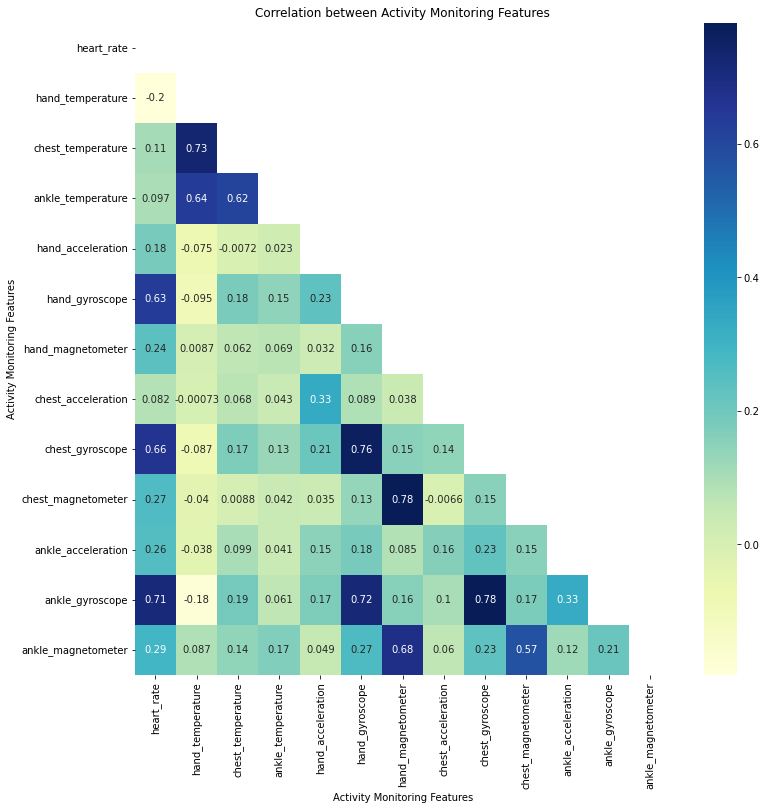

In [18]:
#creating a correlation matrix to identify relevant and unrelated columns
def display_correlation(_df):
    corr = _df.corr(method='spearman')
    mask = np.triu(np.ones_like(corr))
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr, cmap="YlGnBu", annot=True, mask=mask)
    plt.xlabel("Activity Monitoring Features")
    plt.ylabel("Activity Monitoring Features")
    plt.title("Correlation between Activity Monitoring Features")
    plt.show()
    
display_correlation(eda_df.drop(columns=['timestamp','activity_id']))

From the correlation matrix we get the following insights:
- `heart_rate` is strongly correlated with **angular velocity**, as `hand_gyroscope`, `chest_gyroscope`, and `ankle_gyroscope` has correlation value of 0.63, 0.66, and 0.71, respectively.
- Magnetometer measure of all the IMUs are highly correlated, as it depends on the surrounding of the subject.


<a name="dda"></a>
### 5.2. Data Distribution Analysis

Data distribution analysis is used to identify relationships between different variables within the data set. It also provides insight into the underlying structure of the data and can help make decisions about the data.

In [19]:
#mapping activities for better visualisation
def map_activities(_df):
    _df['activity_id'].replace(
        {1 :'Lying',
         2 :'Sitting',
         3 :'Standing',
         4 :'Walking',
         5 :'Running',
         6 :'Cycling',
         7 :'Nordic Walking',
         9 :'Watching TV',
         10 :'Computer Work',
         11 :'Car Driving',
         12 :'Ascending Stairs',
         13 :'Descending Stairs',
         16 :'Vacuum Cleaning',
         17 :'Ironing',
         18 :'Folding Laundry',
         19 :'House Cleaning',
         20 :'Playing Soccer',
         24 :'Rope Jumping'}, inplace = True)
    
#function to plot distribution
def distribution_plot(_df, x, y, x_label, y_label , title, figsize=(15,10), map_activity=False):
    if map_activity:
        map_activities(_df)
    fig, ax = plt.subplots(figsize=figsize)
    
    #condition for ploting a horizontal or vertival distribution
    if map_activity:
        ax.barh(_df[x],_df[y])
    else:
        ax.bar(_df[x],_df[y])
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

#### Frequency of records per Subject

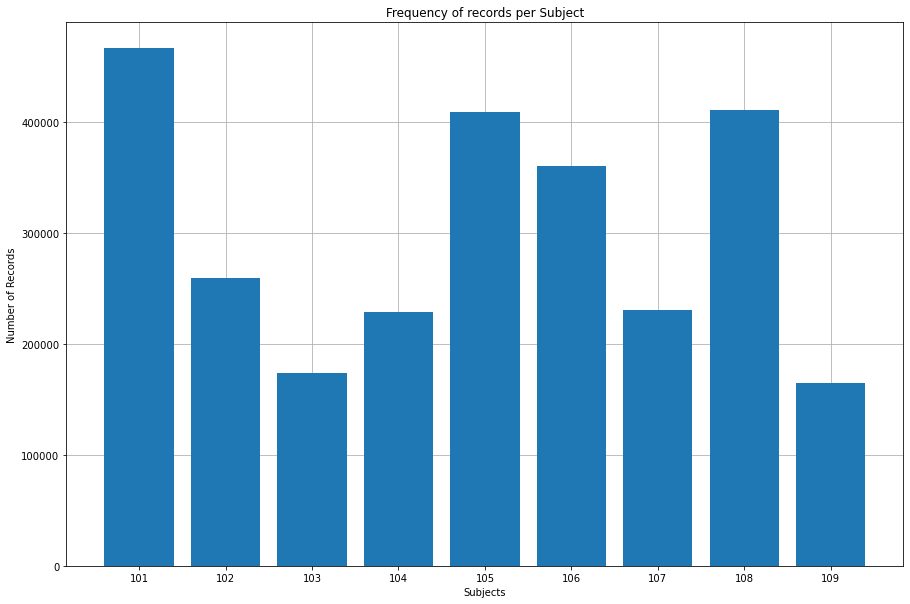

In [20]:
distribution_plot(df.groupby('subject_id')['timestamp'].count().reset_index(), 'subject_id', 'timestamp',
                  x_label='Subjects', y_label='Number of Records', title='Frequency of records per Subject')

The distribution plot demonstrates the unbalanced nature of the data by highlighting the wide variation in records per Subject.


#### Frequency of records per Activity

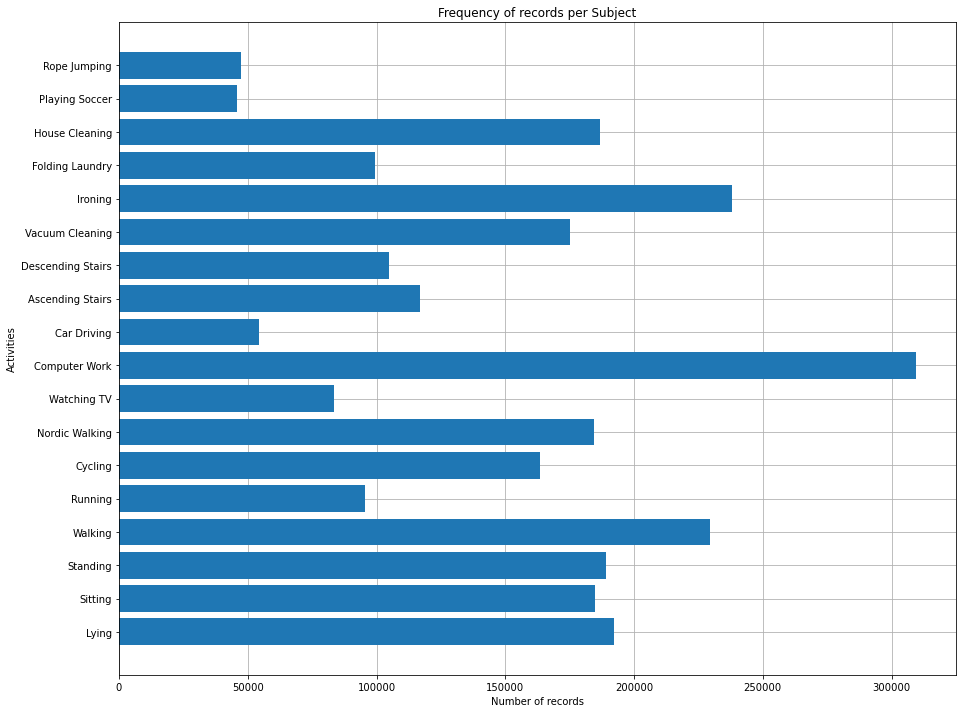

In [21]:
distribution_plot(df.groupby('activity_id')['timestamp'].count().reset_index(), 'activity_id', 'timestamp',
                  x_label='Number of records', y_label='Activities', title='Frequency of records per Subject',
                  figsize=(15,12), map_activity=True)

The distribution plot demonstrates the unbalanced nature of the data by highlighting the wide variation in records per Activity.  


#### Activity Distribution across all Subjects

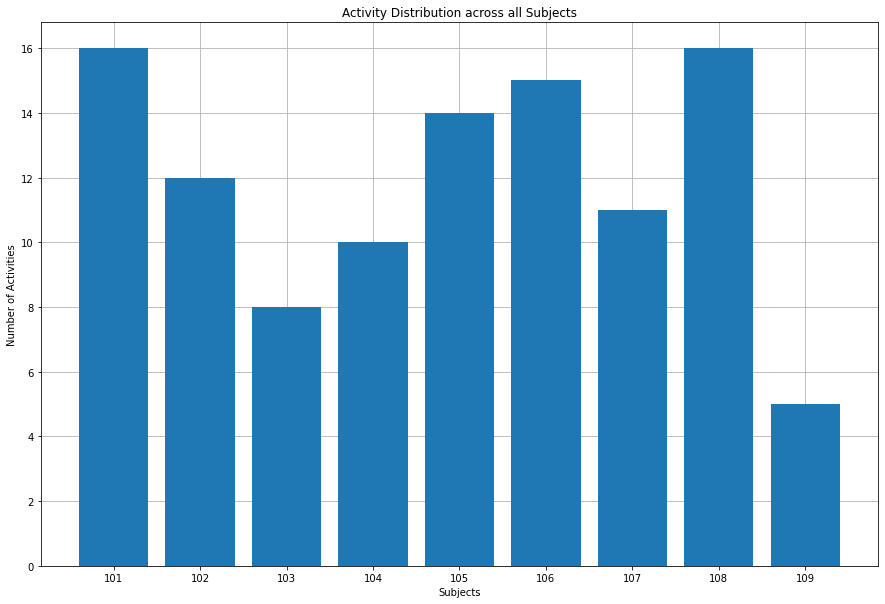

In [22]:
distribution_plot(df.groupby('subject_id')['activity_id'].nunique().reset_index(), 'subject_id', 'activity_id',
                  x_label='Subjects', y_label='Number of Activities', title='Activity Distribution across all Subjects')

The unbalanced records for each subject are explained by the activity distribution plot across all subjects. Because subject 101 performed 16 activities, it has the most records, while subject 109 performed 5, the fewest activities of an individual in this study, and as a result, had the fewest records.

<a name="heartrate_analysis"></a>
### 5.3. Heart Rate Analysis

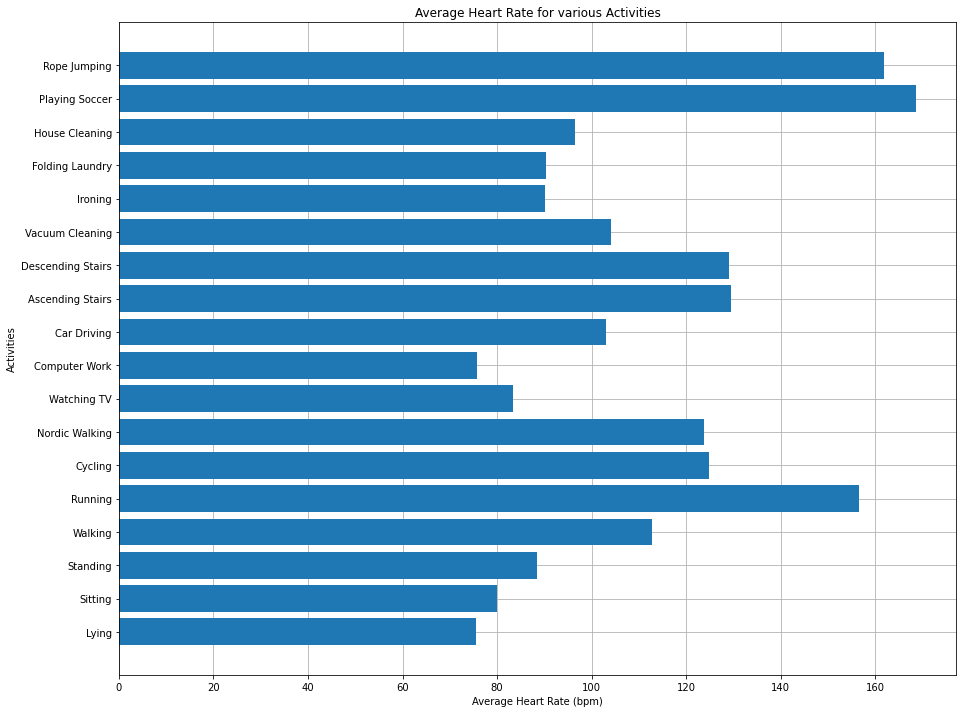

In [23]:
distribution_plot(df.groupby('activity_id')['heart_rate'].mean().reset_index(), 'activity_id', 'heart_rate',
                  x_label='Average Heart Rate (bpm)', y_label='Activities', title='Average Heart Rate for various Activities',
                  figsize=(15,12), map_activity=True)

We can see from the Heart Rate analysis for each activity that `sedentary activities` have a lower average heart rate and `intense activities` have a higher average heart rate.

> `Sedentary Activities:` Lying, Sitting, Standing, Watching TV, Computer Work, Ironing and Folding Laundry.<br>
> `Intense Activities:` Walking, Running, Cycling, Nordic Walking, Car Driving, Ascending Stairs, Descending Stairs, Vacuum Cleaning, House Cleaning, Playing Scocer and Rope Jumping.

`Rope Jumping` and `playing soccer` has the highest average heart rate as those are the most intense activities here.

<a name="acceleration_analysis"></a>
### 5.4. Acceleration Analysis

In [24]:
#function to plot 3 independent values per activity
def comparision_plot(_df, y_label, title, plot='bar'):
    map_activities(_df)    
    _df.set_index('activity_id', inplace=True)
    ax = _df.plot(kind=plot, figsize = (15,10), grid=True)
    ax.set_xticks(np.arange(len(_df)))
    ax.set_xticklabels(_df.index, rotation=90)
    ax.set_axisbelow(True)
    plt.xlabel('Activities')
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

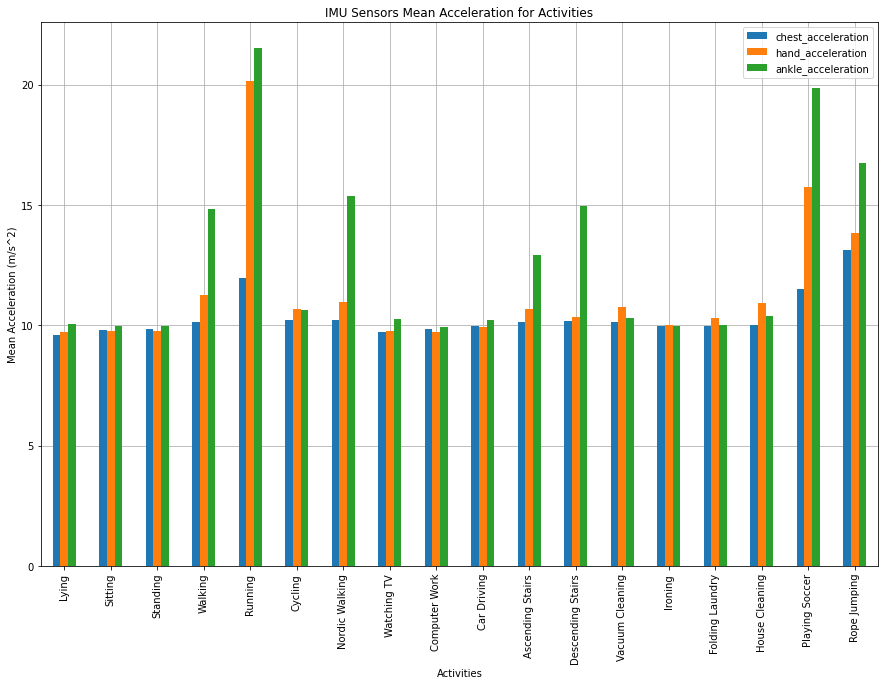

In [25]:
comparision_plot(df.groupby('activity_id')[['chest_acceleration','hand_acceleration','ankle_acceleration']].mean().reset_index(),
                y_label='Mean Acceleration (m/s^2)', title='IMU Sensors Mean Acceleration for Activities')

Insights from the bar plot of mean acceleration vs activities:
- As anticipated, physically easy activities like lying down, sitting up straight, standing up, watching TV, computer worl, car driving, vacuum cleaning, ironing, folding laundary, and house cleaning have relatively low mean accelerations for the 3 IMUs. 
- Running and rope jumping are physically demanding activities that have significantly high mean acceleration values for the ankle and hand. 
- Cycling is an exception, but other leg-intensive activities like walking, Nordic walking, and ascending and descending stairs have high ankle acceleration.

<a name="velocity_analysis"></a>
### 5.5. Angular Velocity Analysis

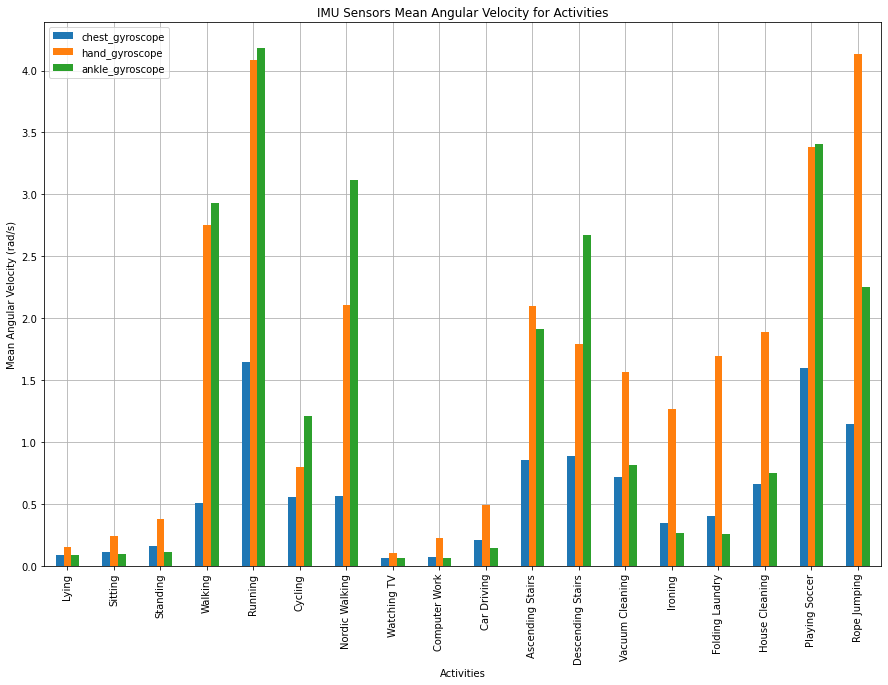

In [26]:
comparision_plot(df.groupby('activity_id')[['chest_gyroscope','hand_gyroscope','ankle_gyroscope']].mean().reset_index(),
                y_label='Mean Angular Velocity (rad/s)', title='IMU Sensors Mean Angular Velocity for Activities')

Insights from the bar plot of mean anugular velocity vs activities:
- Except for ironing and folding laundary, which has a significant mean angular velocity in the hand, physically undemanding activities have low angular velocities for each IMUs.
- Both the hand and the ankle experience high mean angular velocity during running $\approx 4.2\, rad/sec$. 
- The mean hand angular acceleration during rope jumping is the highest $\approx 4.3\, rad/sec$, but ankle acceleration is low in comparison to hand acceleration.
- Mean ankle angular velocity is significantly higher when going down stairs than when going up.

<a name="magnetic_analysis"></a>
### 5.6. Magnetic Field Analysis

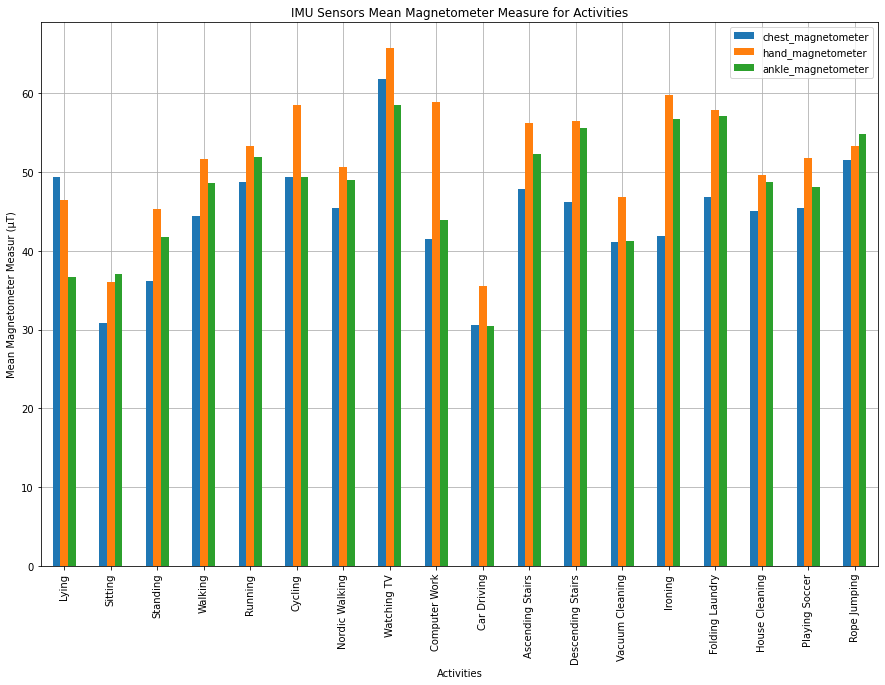

In [27]:
comparision_plot(df.groupby('activity_id')[['chest_magnetometer','hand_magnetometer','ankle_magnetometer']].mean().reset_index(),
                y_label='Mean Magnetometer Measur (μT)', title='IMU Sensors Mean Magnetometer Measure for Activities')

There are no activities in the given set of activities that interfere with the magnetic field, so the magnetic field measurement only depends on the location where the person is performing the activity (the Earth's magnetic field), not on the activity itself, making it of little use if our goal is simply to identify which activity the person is performing. Therefore, the Mean Magnetometer Measure for the activites looks so random and doesn't provide any significance correlation.

<a name="temprature_analysis"></a>
### 5.7. Temprature Analysis

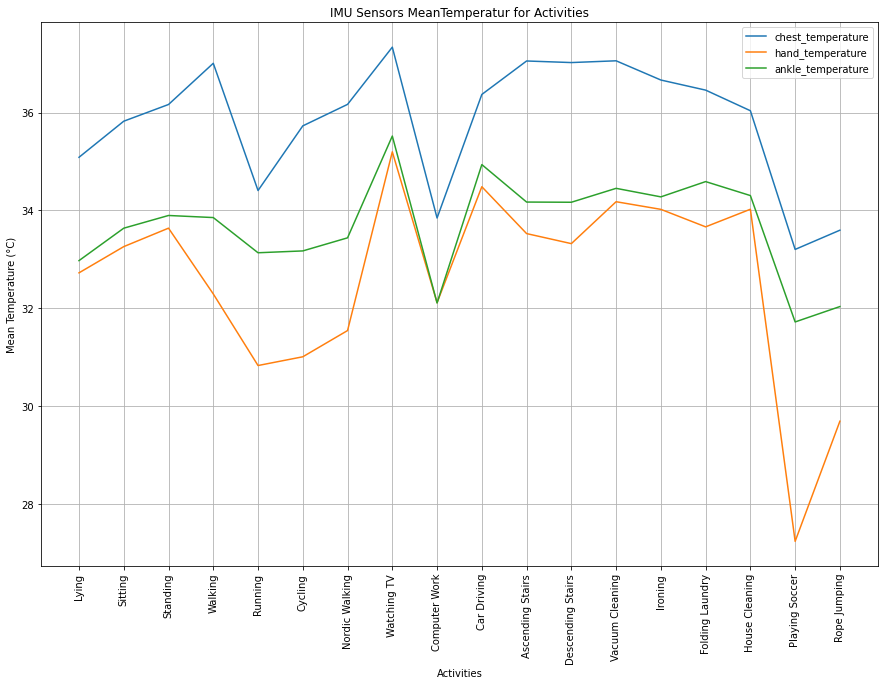

In [28]:
comparision_plot(df.groupby('activity_id')[['chest_temperature','hand_temperature','ankle_temperature']].mean().reset_index(),
                y_label='Mean Temperature (°C)', title='IMU Sensors MeanTemperatur for Activities', plot='line')

As hand and ankle temperatures can be influenced by the environment and recent physical activity, the chest temperature is the most accurate indicator of a person's core body temperature. Therefore, for all activities, we further analyse chest temperature.

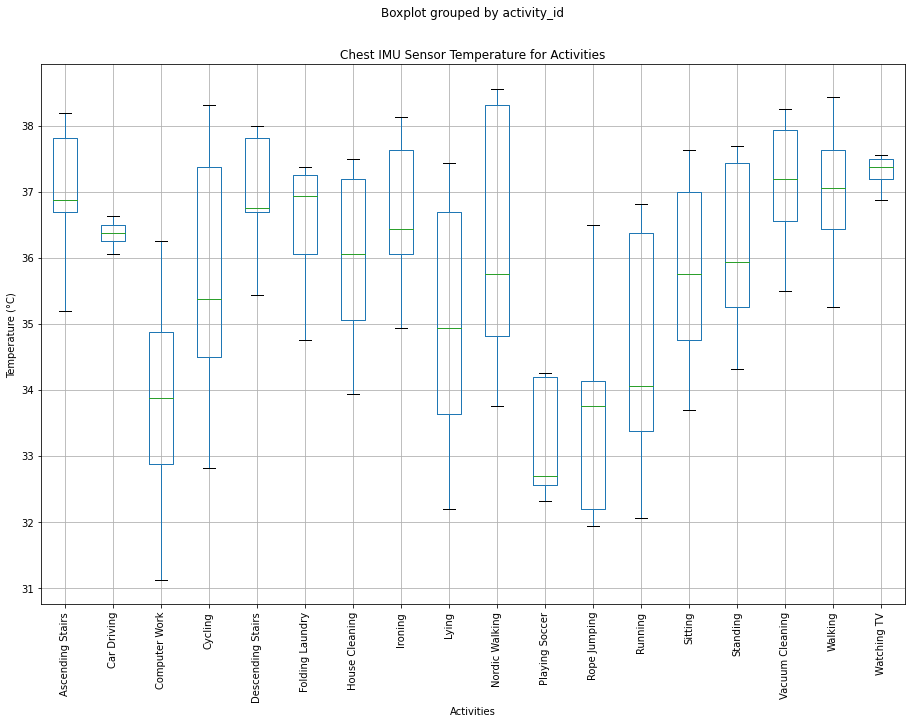

In [29]:
def box_plot(_df):
    map_activities(_df)
    _df.boxplot(by='activity_id',figsize=(15,10), rot=90)
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Activities')
    plt.title('Chest IMU Sensor Temperature for Activities')
    plt.show()
    
box_plot(df.loc[:,('activity_id','chest_temperature')])

Here, the plot shows correlation between temprature and household work(folding laundry, house cleaning, ironing, and vacuum cleaning). Also, walking and going up and down the stairs has a median temperature more than 36°C along with watching TV and car driving.

<a name="hypothesis_testing"></a>
## 6. Hypothesis Testing
To determine if there is enough evidence in a sample of data to infer that a certain condition is true for the entire population we perform Hypothesis testing.

<a name="hypothesis1"></a>
### 6.1. Hypothesis Case 1
We split the activities into two categories—`sedentary activities` and `intense activities`—to see if **heart rate** has any relation with the **intensity of the activity**.
> `Sedentary Activities:` Lying, Sitting, Standing, Watching TV, Computer Work, Ironing and Folding Laundry.<br>
> `Intense Activities:` Walking, Running, Cycling, Nordic Walking, Car Driving, Ascending Stairs, Descending Stairs, Vacuum Cleaning, House Cleaning, Playing Scocer and Rope Jumping.

**Hypothesis:** If the heart rate of a subject is higher, then it is likely doing an intense activity.

**Null Hypothesis:** There is no difference between mean heart rate of sedentary and intense activities.

**Alternative Hypothesis:** The mean heart rate of intense activities is greater than the mean heart rate of sedentary activities.

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**H<sub>o</sub>: µ<sub>intense</sub> = µ<sub>sedentary</sub>** &emsp;&emsp;&emsp;&emsp;**H<sub>a</sub>: µ<sub>intense</sub> > µ<sub>sedentary</sub>**

In [30]:
#dividing heart rate records by sedentary and intense activities
sedentary_heart_rate = ht_df['heart_rate'][(df['activity_id'] == 1) | (df['activity_id'] == 2) | (df['activity_id'] == 3) |
                        (df['activity_id'] == 9) | (df['activity_id'] == 10) | (df['activity_id'] == 17) |
                        (df['activity_id'] == 18)]
intense_heart_rate = ht_df['heart_rate'][~ht_df.index.isin(sedentary_heart_rate.index)]
data1 = sedentary_heart_rate.to_numpy()
data2 = intense_heart_rate.to_numpy()

#function for calculating the p_value
def intensity_testing(data1,data2):
    mean_p_value = []
    #running the test for 10 times
    for _ in range(10):
        #bootstraping the data
        _sedentary = [random.choice((data1)) for _ in range(len(data1))]
        _intense = [random.choice((data2)) for _ in range(len(data2))]
        p_value = ttest_ind(_intense, _sedentary, equal_var=False, alternative="greater")[1]
        mean_p_value.append(p_value)
    return np.mean(mean_p_value)

#getting p-value from the ttest_ind on 2 populations, with a population size > 30.
p_value = intensity_testing(data1,data2)
print(f'one-tail p-value from scipy: {p_value}')

one-tail p-value from scipy: 0.0


The probability that we will reject the null hypothesis, assuming it is true, is represented by the significance level ($a$).

Here, the p-value calculated is 0.0, which is actually $\approx 0.0$. This is because of the built-in rounding rules of the computer system, it was just rounded down and reported as 0.0.

Now, at significance level($α$) of 0.01 we **accept the alternative hypothesis** as p-value<0.01, concluding that the mean heart rate of intense activities is greater than the mean heart rate of sedentary activities.

<a name="hypothesis2"></a>
### 6.2. Hypothesis Case 2

In order to test if **heart rate** has any direct correlation with **angular velocity** measured by the IMU sensor, we perform the following hypothesis test using `spearmanr` method from `scipy.stats` package.

**Hypothesis:** If the heart rate of a subject is higher, then it is likely to have a higher angular velocity.

**Null Hypothesis:** There is no correlation between heart rate and angular velocity.

**Alternative Hypothesis:** There is positive correlation between heart rate and angular velocity.

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**H<sub>o</sub>: Correlation = 0** &emsp;&emsp;&emsp;&emsp;**H<sub>a</sub>: Correlation > 0**

In [31]:
#function for coorelation testing
def corr_testing(feature1,feature2,ht_df):
    mean_corr = []
    mean_p_value = []
    data1 = ht_df[feature1].to_numpy()
    data2 = ht_df[feature2].to_numpy()
    #running the test for 10 times
    for _ in range(10):
        #bootstraping the data
        _d1 = [random.choice((data1)) for _ in range(len(data1))]
        _d2 = [random.choice((data2)) for _ in range(len(data2))]
        #spearmanr returns correlation and p_value as output
        corr,p_value = spearmanr(ht_df[feature1],ht_df[feature2])
        mean_corr.append(corr)
        mean_p_value.append(p_value)
    return np.mean(mean_corr), np.mean(mean_p_value)

#correlation for chest angular velocity
corr_chest,p_value_chest = corr_testing('heart_rate','chest_gyroscope',ht_df)
print('Heart Rate and Angular Velocity of IMU sensor on chest')
print('Mean Correlation = {}'.format(corr_chest))
print('Mean p_value = {}'.format(p_value_chest))

#correlation for hand angular velocity
corr_hand,p_value_hand = corr_testing('heart_rate','hand_gyroscope',ht_df)
print('Heart Rate and Angular Velocity of IMU sensor on hand')
print('Mean Correlation = {}'.format(corr_hand))
print('Mean p_value = {}'.format(p_value_hand))

#correlation for ankle angular velocity
corr_ankle,p_value_ankle = corr_testing('heart_rate','ankle_gyroscope',ht_df)
print('Mean Heart Rate and Angular Velocity of IMU sensor on ankle')
print('Mean Correlation = {}'.format(corr_ankle))
print('Mean p_value = {}'.format(p_value_ankle))

Heart Rate and Angular Velocity of IMU sensor on chest
Mean Correlation = 0.6639755124884854
Mean p_value = 0.0
Heart Rate and Angular Velocity of IMU sensor on hand
Mean Correlation = 0.6330534478678863
Mean p_value = 0.0
Mean Heart Rate and Angular Velocity of IMU sensor on ankle
Mean Correlation = 0.7137650912479041
Mean p_value = 0.0


At significance level($α$) of 0.01 we **reject the null hypothesis** as p-value<0.01, concluding that there is positive correlation between heart rate and angular velocity. We can say this with a confidence level of 99%, as $α$=0.01.

<a name="hypothesis3"></a>
### 6.3. Hypothesis Case 3
To determine whether ankle acceleration has any connection to the movements in an activity, we divided the activities into two categories: `light activities` and `vigorous activities`.
> `Light Activities:` Lying, Sitting, Standing, Watching TV, Computer Work, Car Driving, Vacuum Cleaning, Ironing, House Cleaning and Folding Laundry.<br>
> `Vigorous Activities:` Walking, Running, Cycling, Nordic Walking, Ascending Stairs, Descending Stairs, Playing Scocer and Rope Jumping.

**Hypothesis:** If the ankle acceleration of a subject is higher, then it is likely doing a vigorous activity.

**Null Hypothesis:** There is no difference between mean ankle acceleration of light and vigorous activities.

**Alternative Hypothesis:** The mean ankle acceleration of vigorous activities is greater than the mean ankle acceleration of light activities.

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**H<sub>o</sub>: µ<sub>vigorous</sub> = µ<sub>light</sub>** &emsp;&emsp;&emsp;&emsp;**H<sub>a</sub>: µ<sub>vigorous</sub> > µ<sub>light</sub>**

In [32]:
#dividing ankle acceleration records by light and vigorous activities
light_ankle_acc = ht_df['ankle_acceleration'][(df['activity_id'] == 1) | (df['activity_id'] == 2) | (df['activity_id'] == 3) |
                        (df['activity_id'] == 9) | (df['activity_id'] == 10) | (df['activity_id'] == 11) |
                        (df['activity_id'] == 16) |(df['activity_id'] == 17) | (df['activity_id'] == 18) |
                        (df['activity_id'] == 19)]
vigorous_ankle_acc = ht_df['ankle_acceleration'][~ht_df.index.isin(light_ankle_acc.index)]
light_acc = light_ankle_acc.to_numpy()
vigorous_acc = vigorous_ankle_acc.to_numpy()

#function for calculating the p_value
def acceleration_testing(data1,data2):
    mean_p_value = []
    #running the test for 10 times
    for _ in range(10):
        #bootstraping the data
        _light = [random.choice((data1)) for _ in range(len(data1))]
        _vigorous = [random.choice((data2)) for _ in range(len(data2))]
        p_value = ttest_ind(_vigorous, _light, equal_var=False, alternative="greater")[1]
        mean_p_value.append(p_value)
    return np.mean(mean_p_value)

#getting p-value from the ttest_ind on 2 populations, with a population size > 30.
p_value = acceleration_testing(light_acc,vigorous_acc)
print(f'one-tail p-value from scipy: {p_value}')

one-tail p-value from scipy: 0.0


At significance level($α$) of 0.01 we **accept the alternative hypothesis** as p-value<0.01, concluding that the mean heart rate of intense activities is greater than the mean heart rate of sedentary activities.

<a name="modelling"></a>
## 7. Modelling

<a name="train_valid_test"></a>
### 7.1. Split data into Train, Valid, and Test Dataset

Splitting data into train, valid, and test datasets to train our model on a training dataset, use a validation dataset to evaluate the model’s performance, and use a test dataset to measure the accuracy of the model on unseen data. This helps us to prevent overfitting and also to measure our model’s generalization ability.

In [33]:
#define response variables as features and true labels as labels
features = df.drop(columns=['timestamp','subject_id','activity_id'])
labels = df['activity_id']

#split the data in training and remaining dataset
X_train, X_remain, y_train, y_remain = train_test_split(features,labels, train_size=0.6)

#now split the remaining dataset into 2 equal parts, valid and test datasets.
X_valid, X_test, y_valid, y_test = train_test_split(X_remain,y_remain, test_size=0.5)

<a name="models"></a>
### 7.2. Models

Now let's create a function calculating the model metrics using *sklean metrics* [[2]](#2).<br>

**Confusion Matrix**

A *confusion matrix* [[3]](#3) is a table used to evaluate the performance of a classification model. It is a table that displays the predicted classifications against the actual classifications. It is a useful tool for understanding the performance of a classification model, as it allows you to see what types of errors the model is making. For example, if the model predicts one class but the actual class is another, then this is called a false positive or a false negative.
- True Positive: TP
- False Positive: FP
- True Negative: TN
- False Negative: FN

**Accuracy:**
\begin{eqnarray*}
A=\frac{TP+TN}{TP+FP+TN+FN}
\end{eqnarray*}

Accuracy  is a measure of how accurately the model is able to predict the correct class for new data. It is calculated as the number of correct predictions divided by the total number of predictions.

**Mean Squared Error:**
\begin{eqnarray*}
MSE = \frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2
\end{eqnarray*}
MSE (Mean Squared Error) is a metric used to measure the performance of a classification model. It is the average of the squared differences between the predicted and actual values.

**Precision:**
\begin{eqnarray*}
P=\frac{TP}{TP+FP}
\end{eqnarray*}

Precision is a metric that measures the accuracy of a model's positive predictions. It is calculated by dividing the number of true positives (predicted positives that are actually positive) by the total number of predicted positives. High precision indicates that the model is returning mostly correct positive predictions.

**Recall:** 
\begin{eqnarray*}
R=\frac{TP}{TP+FN}
\end{eqnarray*}

Recall is a metric that measures the ability of a classification model to identify all relevant instances. It is calculated by dividing the number of true positives (i.e. correctly identified positive cases) by the total number of relevant cases. High recall indicates that the model is able to accurately identify all relevant instances.

**F1-score:**
\begin{eqnarray*}
F1 = \frac{2\times P\times R}{P+R}
\end{eqnarray*}

F1-score is a measure of a classification model's accuracy. It is the harmonic mean of precision and recall. If the f1 score is 1.0 this means recall and precision are equally important. 


In [34]:
#function to get model metrics
def model_metrics(true_values,pred_values,cm_flag=False):
    accuracy = metrics.accuracy_score(true_values, pred_values)
    mse = metrics.mean_squared_error(true_values, pred_values)
    precision = np.mean(metrics.precision_score(true_values,pred_values, average=None))
    recall = np.mean(metrics.recall_score(true_values,pred_values, average=None))
    f1 = np.mean(metrics.f1_score(true_values,pred_values, average=None))
    if cm_flag:
        cm = metrics.confusion_matrix(true_values,pred_values)
        return accuracy,mse,precision,recall,f1,cm
    return accuracy,mse,precision,recall,f1
        

In [35]:
#activity list for visualization
def get_activity_list(_df):
    map_activities(_df)    
    _df.set_index('activity_id', inplace=True)
    return list(_df.index)
    
activity_list = get_activity_list(df.groupby('activity_id')['timestamp'].count().reset_index())

Using pandas *table visualisation* [[4]](#4) for displaying model results.

In [36]:
#function to display results
def display_results(accuracy,mse,precision,recall,f1,cm,activity_list):
    #defining pandas table style properties
    caption = {
        "selector": "caption",
        "props": "text-align: center; font-size: 125%; color: black; font-weight:bold;"
    }
    cell_hover = {
        "selector": "td:hover",
        "props": "background-color: #FFFFE0;"
    }
    headers = {
        "selector": "th:not(.index_name)",
        "props": "background-color: skyblue; color: white;"
    }
    col_heading = {
        "selector": "th.col_heading",
        "props": "writing-mode: vertical-rl; transform: rotateZ(180deg);"
    }
    #creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting
    cm_df = pd.DataFrame(cm, index=pd.Index(activity_list, name='Actual Labels') ,
                         columns = pd.Index(activity_list, name='Predicted Labels'))
    #plotting the confusion matrix
    display(cm_df.style.set_table_styles([cell_hover, headers, caption, col_heading]).set_caption("Confusion Matrix"))
    
    print("Accuracy: ",accuracy)
    print("Mean Standard Error: ",mse)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-score: ", f1)

####  Logistic Regression
*Logistic regression* [[5]](#5) is a type of supervised machine learning algorithm used for classification problems. It is used to predict the probability of a categorical dependent variable based on one or more independent variables. Logistic regression is based on the concept of logistic function, which is a S-shaped curve that can take any real-valued number and map it into a value between 0 and 1. This output can be interpreted as the probability or odds of the occurrence of a certain event. The logistic regression model is trained using maximum likelihood estimation to find the best parameters that maximize the likelihood of observing the sample data.

In [37]:
#function to test logistic regression model
def test_lr(X_train,y_train,X_test,y_test):
    #intializing model instance
    lr = LogisticRegression(n_jobs=-1)
    #training model
    lr.fit(X_train,y_train)
    #predicting labels
    y_pred = lr.predict(X_test)
    #calculating model metrics
    accuracy,mse,precision,recall,f1,cm = model_metrics(y_test,y_pred,cm_flag=True)
    #displaying results
    display_results(accuracy,mse,precision,recall,f1,cm,activity_list)
    
test_lr(X_train,y_train,X_test,y_test)

Predicted Labels,Lying,Sitting,Standing,Walking,Running,Cycling,Nordic Walking,Watching TV,Computer Work,Car Driving,Ascending Stairs,Descending Stairs,Vacuum Cleaning,Ironing,Folding Laundry,House Cleaning,Playing Soccer,Rope Jumping
Actual Labels,,,,,,,,,,,,,,,,,,
Lying,33776,153,375,13,0,246,9,627,840,0,0,32,596,1408,6,240,0,0
Sitting,446,25441,5377,22,0,38,0,3368,241,0,0,0,722,1220,0,101,0,0
Standing,3614,5859,11798,23,0,6,0,32,3213,11,3,1,5422,7254,2,689,0,0
Walking,311,0,114,34610,14,1136,4939,346,316,99,107,316,1700,627,32,1056,0,3
Running,164,0,0,1117,12162,566,1694,2,79,0,104,39,173,2,0,22,1073,1884
Cycling,23,7,102,1335,68,26148,2044,40,58,0,608,521,1399,40,3,14,0,0
Nordic Walking,72,108,132,9748,1029,3445,19783,44,98,18,1046,802,601,84,1,188,0,11
Watching TV,9,0,0,0,0,0,0,15889,274,0,0,0,0,3,1,553,0,0
Computer Work,3110,1708,908,21,0,394,0,2036,45694,3,61,16,1033,5741,0,1202,0,0


Accuracy:  0.5678126914952505
Mean Standard Error:  31.765818086223078
Precision:  0.5245765266799665
Recall:  0.5242974552716846
F1-score:  0.5086416390787877


Since the accuracy, precision, recall, and f1-score all fall between 50 and 56%, the results of logistic regression are not promising. A prediction with a 56% accuracy is basicaly random.

#### Random Forest Classifier
*Random Forest Classifier* [[6]](#6) is an ensemble machine learning algorithm that is used to classify objects based on their attributes. It works by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. It is a supervised learning algorithm that can be used both for classification and regression tasks. The main advantages of Random Forest Classifier are its ability to handle large datasets, its high accuracy, and its robustness to noisy data and outliers.

In [38]:
#fnction to test random forest model
def test_rf(X_train,y_train,X_test,y_test):
    #intializing model instance
    rf = RandomForestClassifier(n_jobs=-1)
    #training model
    rf.fit(X_train,y_train)
    #predicting labels
    rf_y_pred = rf.predict(X_test)
    #calculating model metrics
    rf_accuracy,rf_mse,rf_precision,rf_recall,rf_f1,rf_cm = model_metrics(y_test,rf_y_pred,cm_flag=True)
    #displaying results
    display_results(rf_accuracy,rf_mse,rf_precision,rf_recall,rf_f1,rf_cm,activity_list)
    
test_rf(X_train,y_train,X_test,y_test)

Predicted Labels,Lying,Sitting,Standing,Walking,Running,Cycling,Nordic Walking,Watching TV,Computer Work,Car Driving,Ascending Stairs,Descending Stairs,Vacuum Cleaning,Ironing,Folding Laundry,House Cleaning,Playing Soccer,Rope Jumping
Actual Labels,,,,,,,,,,,,,,,,,,
Lying,38321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sitting,0,36975,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Standing,0,4,37904,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0
Walking,0,0,0,45725,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Running,0,0,0,0,19079,0,0,0,0,0,0,0,0,0,0,0,0,2
Cycling,0,0,0,0,0,32410,0,0,0,0,0,0,0,0,0,0,0,0
Nordic Walking,0,0,0,0,0,0,37210,0,0,0,0,0,0,0,0,0,0,0
Watching TV,0,0,0,0,0,0,0,16729,0,0,0,0,0,0,0,0,0,0
Computer Work,0,0,0,0,0,0,0,0,61927,0,0,0,0,0,0,0,0,0


Accuracy:  0.99982967914884
Mean Standard Error:  0.01631007281216387
Precision:  0.9998169667581123
Recall:  0.999825137543144
F1-score:  0.9998210507095586


With a 99% accuracy rating and a mean standard error (MSE) of 0.01, the Random Forest Classifier produces extremely good results.

#### K-Means
*K-means clustering* [[7]](#7) is an unsupervised learning algorithm used for clustering data points into K clusters. It works by randomly initializing K cluster centroids and then assigning each data point to the cluster whose centroid is closest. The centroids are then updated by taking the mean of all the data points assigned to the cluster. This process is repeated until the centroids no longer move.

**Intertia:** Kmeans inertia is a measure of the clustering quality. It is the sum of squared distances between each observation and its closest centroid. A lower inertia value indicates a better clustering quality, which means that the points in a given cluster are more tightly grouped.

**Adjusted Rand Index (ARI):** *K-Means ARI (Adjusted Rand Index)* [[8]](#8) is a measure of how well the clusters produced by the k-means clustering algorithm match the actual labels given to the data. The ARI ranges from -1 to 1, with higher scores indicating better cluster matching. A score of 1 indicates perfect matching and a score of 0 indicates no better than random grouping.

The number of clusters for k-means will be 18, as we already know there are 18 activities.

In [39]:
#function to test k-means clustering model
def k_means(n_clust, X_train, X_test, y_test):
    #using the standardisation function to normalise
    k_train = StandardScaler().fit_transform(X_train)
    k_test = StandardScaler().fit_transform(X_test)
    #intializing model instance
    k_means = KMeans(n_clusters = n_clust)
    #training model
    k_means.fit(k_train)
    #predicting labels
    y_pred = k_means.predict(k_test)
    #create a dataFrame with pred_label and actual_label as columns
    _df = pd.DataFrame({'pred_label': y_pred, 'actual_label': y_test})
    #create crosstab
    df_ct = pd.crosstab(_df['pred_label'], _df['actual_label'])
    display(df_ct)
    #printing the values for inertia and ARI
    print('Inertia: ',k_means.inertia_)
    print('ARI: ',metrics.adjusted_rand_score(y_test, y_pred))

In [40]:
k_means(18, X_train, X_test, y_test)

actual_label,1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24
pred_label,,,,,,,,,,,,,,,,,,
0,133,0,0,1249,1192,17416,7782,0,22,0,236,182,0,0,0,18,3268,2325
1,3,12984,14278,495,0,508,726,0,3074,0,150,46,11,399,0,3358,0,0
2,21772,112,4943,289,151,192,11,0,151,4791,513,567,3201,1400,1169,5086,0,0
3,106,124,347,12184,287,98,3677,0,78,139,2301,1024,1950,1143,793,2282,21,630
4,2,0,0,3,6559,40,7,0,0,0,12,22,0,0,0,2,4392,2990
5,15,3,7,6085,2931,41,5739,0,4,6,1708,4138,247,21,2,617,62,175
6,3,2,2,11765,858,291,9916,0,2,0,2972,3500,128,6,1,296,105,229
7,26,0,5,2966,154,351,2359,111,1,6,4331,3236,1057,357,1639,6128,0,22
8,1,1,0,0,1322,16,256,0,0,0,6,3,2,0,2,13,210,8


Inertia:  7585771.034017302
ARI:  0.25620951052144003


K-means clustering doesn't produce good results because the clusters are relatively dispersed (inertia value: $7.5*10^6$) and the ARI is only slightly better than random grouping (0.25).

<div class="alert alert-info">
<b>Note:</b> The silhouette score, which would have given us a better idea of how effective the clustering is, was not computed here because it was taking too long given the size of the dataset.
</div>

Let's now test whether using the number of clusters suggested by the elbow method can enhance K-Means.

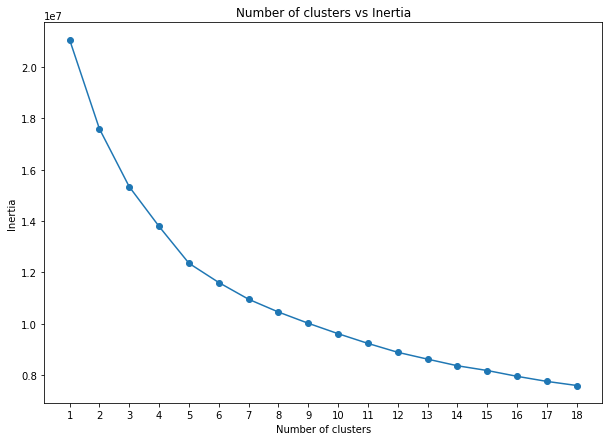

In [41]:
#checking the optimal number of clusters 
inertia = []
cluster_components = range(1,len(activity_list)+1)

#computing inertia for all the possible clusters.
for k_num in cluster_components:
    #using the standardisation function to normalise
    k_train = StandardScaler().fit_transform(X_train)
    model = KMeans(n_clusters=k_num)
    model.fit(k_train)
    inertia.append(model.inertia_)
    
#plotting the number of clusters vs inertia
plt.figure(figsize=(10,7))
plt.plot(cluster_components, inertia, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Number of clusters vs Inertia')
plt.xticks(cluster_components)
plt.show()

In [42]:
k_means(6, X_train, X_test, y_test)

actual_label,1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24
pred_label,,,,,,,,,,,,,,,,,,
0,18673,8180,4728,121,465,3273,1386,0,41257,0,0,0,0,0,0,2192,267,287
1,214,43,101,37090,3709,5332,20608,5,19,58,13607,13270,5594,887,563,4457,0,1044
2,139,0,0,263,8793,13495,10271,0,41,0,6,7,0,0,0,0,7486,5937
3,1006,4604,4675,3677,351,6708,2270,16724,12167,260,5421,3898,4620,14983,9501,12449,0,138
4,1,2,0,3,5502,26,451,0,0,0,58,257,4,3,6,43,1442,1979
5,18288,24147,28423,4572,261,3576,2224,0,8443,10613,4371,3706,24494,31856,9863,18113,0,110


Inertia:  11604496.499084475
ARI:  0.13641838896597205


Using optimal clusters didn't improve the k-means because the ARI is 0.13, which is closer to 0.

<a name="pca_models"></a>
### 7.3. Models using PCA

#### Principal component analysis (PCA)
*Principal component analysis (PCA)* [[9]](#9) is a statistical technique used to reduce the dimensionality of data by transforming it into a set of orthogonal variables, known as principal components. It rotates the data in such a way that the variance of each variable is maximized while minimizing the correlations between the variables. We are using PCA for dimensionality reduction. It can also be used to identify patterns and structure in data, as well as in feature extraction, to reduce the complexity of the data and make it more manageable for analysis.

We will use  Singluar Value Decomposition(SVD), as it provides a more accurate representation of the data by decomposing it into its constituent parts. Furthermore, SVD is more robust and can better handle data with missing values or outliers.

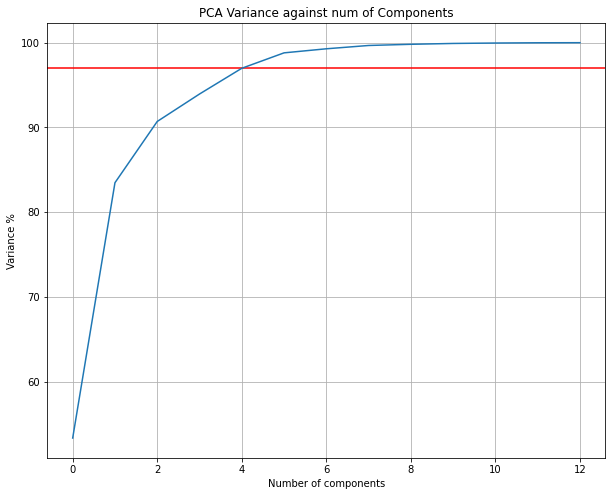

In [43]:
#intializing pca instance using decomp
pca = decomp.PCA(random_state = 27)
pca.fit(X_train)

#computing the cumulative sum of variance for the number of components.
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#plot of PCA Variance against num of Components
fig, ax = plt.subplots(figsize=(10,8))
plt.title("PCA Variance against num of Components")
plt.ylabel("Variance %")
plt.xlabel("Number of components")
plt.axhline(97, color="red")
plt.grid()
plt.plot(var)
plt.show()

Just 4 components account for 97% of the variance.

In [44]:
#creating PCA object for 4 features
pca = decomp.PCA(n_components=4, random_state=27)
#fitting X_train
pca_X_train=pca.fit_transform(X_train)
#using the same pca object to transform X_test to use the same mean and variance as it is calculated from our training data
pca_X_test=pca.transform(X_test)

In [45]:
test_lr(pca_X_train,y_train,pca_X_test,y_test)

Predicted Labels,Lying,Sitting,Standing,Walking,Running,Cycling,Nordic Walking,Watching TV,Computer Work,Car Driving,Ascending Stairs,Descending Stairs,Vacuum Cleaning,Ironing,Folding Laundry,House Cleaning,Playing Soccer,Rope Jumping
Actual Labels,,,,,,,,,,,,,,,,,,
Lying,34311,346,0,37,0,154,0,486,839,0,0,0,660,727,67,694,0,0
Sitting,254,26553,1787,133,0,0,0,3045,2439,238,0,0,880,996,157,494,0,0
Standing,4126,5466,7153,7,0,0,0,111,5725,20,0,0,6181,6540,352,2246,0,0
Walking,175,2,328,17867,0,3101,10461,684,3,143,1,531,5046,825,29,6527,0,3
Running,166,0,1,950,12842,726,2318,18,16,0,156,628,440,1,0,74,353,392
Cycling,24,12,6,6260,0,17217,7203,112,136,0,213,436,604,9,0,167,11,0
Nordic Walking,42,107,105,7086,327,4245,21058,62,23,28,755,351,1878,23,0,1111,0,9
Watching TV,3,0,0,0,0,0,0,16101,0,0,0,0,0,0,0,625,0,0
Computer Work,4,7093,851,43,0,0,0,74,40156,0,0,0,411,12901,0,394,0,0


Accuracy:  0.4667957649350096
Mean Standard Error:  46.07624635059807
Precision:  0.39160765305858813
Recall:  0.4083938585138603
F1-score:  0.38067112321170027


We see a 10% accuracy loss in logistic regression.

In [46]:
test_rf(pca_X_train,y_train,pca_X_test,y_test)

Predicted Labels,Lying,Sitting,Standing,Walking,Running,Cycling,Nordic Walking,Watching TV,Computer Work,Car Driving,Ascending Stairs,Descending Stairs,Vacuum Cleaning,Ironing,Folding Laundry,House Cleaning,Playing Soccer,Rope Jumping
Actual Labels,,,,,,,,,,,,,,,,,,
Lying,38223,0,0,1,2,1,1,0,1,24,8,2,7,14,3,34,0,0
Sitting,0,36862,35,4,0,0,7,0,1,1,1,0,25,20,4,16,0,0
Standing,1,21,37553,14,0,0,1,0,19,1,0,1,62,158,29,67,0,0
Walking,5,8,64,40066,140,1100,2717,2,9,116,271,130,559,77,44,337,59,22
Running,6,0,1,376,15880,214,1158,2,0,11,329,164,50,4,0,15,529,342
Cycling,2,0,0,1443,57,28513,1482,0,5,2,396,138,177,5,2,125,36,27
Nordic Walking,2,4,4,2878,262,1322,31642,7,5,11,343,129,226,40,10,164,35,126
Watching TV,0,0,0,0,0,0,0,16632,0,0,1,0,0,0,40,56,0,0
Computer Work,0,5,42,5,0,0,0,0,61777,1,1,0,23,21,22,30,0,0


Accuracy:  0.933584124615621
Mean Standard Error:  3.971156534118784
Precision:  0.9297881984430069
Recall:  0.9225152527173281
F1-score:  0.9258531183151426


The accuracy of the Random Forest Classifier is reduced by 6%, and the MSE has increased from 0.01 to 3.9.

In [47]:
k_means(18, pca_X_train, pca_X_test, y_test)

actual_label,1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24
pred_label,,,,,,,,,,,,,,,,,,
0,12519,79,1401,857,148,372,119,0,153,3648,752,671,5959,12,0,4665,0,0
1,0,133,0,19351,3108,8280,18196,0,0,35,4825,2958,1891,309,0,160,752,1309
2,219,240,5146,8184,43,324,931,0,13768,87,356,1075,4672,8171,4338,4031,6,0
3,170,21,2122,535,48,109,123,0,25096,616,163,94,1781,757,918,5482,8,0
4,0,25,28,0,2,0,0,0,10069,0,132,224,61,1938,541,54,0,0
5,842,0,0,463,275,111,130,0,73,216,1398,2100,856,24,0,1317,39,0
6,0,0,0,0,10633,45,5,0,0,0,3129,3865,0,0,0,0,7530,4502
7,77,0,0,8489,661,16397,10511,0,0,697,5774,3120,3631,0,0,217,855,1237
8,0,6,83,9,0,8,0,0,8007,88,669,1631,706,12511,2969,866,0,0


Inertia:  1292125.2130088971
ARI:  0.2105539721266524


The inertia improved by $6.3*10^6$ while the ARI suffered no notable loss. K-Means in combination with PCA is advised.

<a name="kfold"></a>
### 7.4. K-fold Cross Validation

*K-fold* [[10]](#10) validation is a method of validating a model's performance by dividing a dataset into a set number of folds (or partitions) and running multiple training and validation experiments. The process involves randomly partitioning the dataset into k-folds, such as 5 or 10, then using one of the folds as the testing set and the remaining k-1 folds as the training set. The process is then repeated k-times, with each of the k-folds used as the testing set once. The average performance across all k-experiments is then reported as the overall performance of the model. This helps to reduce overfitting, as the model is tested on data it hasn't seen before.

In [48]:
#define cross-validation method to use
kf = KFold(n_splits=5, random_state=27, shuffle=True)

def model_evaluation_kfold(model,kf,features,labels):
    #intialising variables for storing model metrics
    accuracy = []
    mse = []
    precision = []
    recall = []
    f1 = []
    cm = []
    #use k-fold CV to evaluate model
    for _, (train_index, test_index) in enumerate(kf.split(features)):
        #training model
        model.fit(features.iloc[train_index], labels.iloc[train_index])
        #predicting results
        label_pred = model.predict(features.iloc[test_index])
        
        #getting model metrics
        a,e,p,r,f = model_metrics(labels.iloc[test_index], label_pred)
        
        #appending model metrics to get the average score at the end
        accuracy.append(a)
        mse.append(e)
        precision.append(p)
        recall.append(r)
        f1.append(f)
        
    return np.mean(accuracy),np.mean(mse),np.mean(precision),np.mean(recall),np.mean(f1)

In [49]:
#list of model classifiers
models = [LogisticRegression(n_jobs=-1), RandomForestClassifier(n_jobs=-1)]

#perforing k-fold for every model
for model in models:
    print(model)
    accuracy,mse,precision,recall,f1 = model_evaluation_kfold(model,kf,X_valid,y_valid)
    print("Accuracy: ",accuracy)
    print("Mean Standard Error: ",mse)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-score: ", f1)
    print("____________________________________________")
    

LogisticRegression(n_jobs=-1)
Accuracy:  0.5580136763028865
Mean Standard Error:  33.342412750957564
Precision:  0.5189430942081191
Recall:  0.5184151064575183
F1-score:  0.5071411344607677
____________________________________________
RandomForestClassifier(n_jobs=-1)
Accuracy:  0.999651953074121
Mean Standard Error:  0.03008383766506858
Precision:  0.9995981004782026
Recall:  0.9995984410487146
F1-score:  0.9995981299711246
____________________________________________


K-Fold cross validation adds confidence to the Random Forest Classifer prediction as the accuracy, precision, recall, and f1-score remains at 99% with the MSE as 0.03.

<a name="summary"></a>
## 8. Summary

In conclusion, this report analysed data on individuals participating in physical activities using evidence from the PAMAP2 dataset. 18 activities were collected over time by the dataset. The purpose of this study was to produce practical insights to aid in the creation of hardware/software that can identify the kind of physical activity a person engages in.

**Handling missing and dirty data**

In order to deal with "NaN" values, these were subsituted by the mean of 1-second time window. The data was then divided equally into a *EDA* dataset and *Hypothesis Testing* dataset in order to ensure that no assumptions were being made about the data.


**Exploratory Data Analysis**

A positive correlation was observed between heart rate and angular velocity in the correlation analysis. Further analysis of heart rate revealed that it changed as the subjects' activities changed. Ankle acceleration also stood out as a potential area for investigation, as it was higher for vigorous activities. 

**Hypothesis Testing**:

 1. ***If*** the heart rate of a subject is higher, ***then*** it is likely doing an intense activity.
 
 > This was **<span style="color:green">true</span>**
 
 2. ***If*** the heart rate of a subject is highers, ***then*** it is likely to have a higher angular velocity.
 
 > This was **<span style="color:green">true</span>**

 3. ***If*** the ankle acceleration of a subject is higher, ***then*** it is likely doing a vigorous activity.
 
 >This was **<span style="color:green">true</span>**


**Modelling**:

Activities were predicted using Logistic Regression, Random Forest Classifier, and K-means, with Random Forest Classifier emerging as the top predictor for the PAMAP2 dataset. To prevent bias, different datasets were used for model training, testing, and validation. Additionally, K-fold cross validation was carried out for Random Forest Classifier, and its high scores indicate that the model is confident.

**Actionable Insights**

- Random Forest Classifier would give the best prediction for the activity being performed.
- Heart rate and angular velocity will serve as reliable indicators of an activity's intensity.
- Ankle acceleration will help in distinguishing still and moving activities.

I'm sure that this big data set could offer more useful information. These are just a few of the insights that were discovered in this PAMAP2 dataset that examined subjects while they were engaged in physical activities and that, hopefully, will aid in the development of hardware and software. More analysis would be required.


<a name="references"></a>
## 9. References
<a name="1"></a>
1. [Archive.ics.uci.edu. (2012). UCI Machine Learning Repository: PAMAP2 Physical Activity Monitoring Data Set](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring)
<a name="2"></a>
2. [Metrics and scoring: quantifying the quality of predictions (scikit-learn 1.2.0)](https://scikit-learn.org/stable/modules/model_evaluation.html)
<a name="3"></a>
3. [Sklearn Confusion_Matrix (scikit-learn 1.2.0)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
<a name="4"></a>
4. [Table Visualization (v1.5.2)](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html)
<a name="5"></a>
5. [Sklearn Logistic Regression (scikit-learn 1.2.0)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
<a name="6"></a>
6. [Sklearn Random Forest Classifier (scikit-learn 1.2.0)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
<a name="7"></a>
7. [K-Means Clustering (scikit-learn 1.2.0)](#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
<a name="8"></a>
8. [Adjusted Rand Index (ARI) (scikit-learn 1.2.0)](#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)
<a name="9"></a>
9. [Sklearn Decomposition PCA (scikit-learn 1.2.0)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
<a name="10"></a>
10. [Sklearn KFold (scikit-learn 1.2.0)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

In [52]:
#this code will word count all of the markdown cells in the notebook saved at filepath
#running the code just for references shows that the references have a word count of 73

import io
from nbformat import read

filepath="22211613_DSRM.ipynb"
reference_count=73

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = read(f, 3)

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-reference_count))

Submission length is 3943
